In [84]:
import pandas as pd
import numpy as np

import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
%matplotlib inline

In [155]:
from scipy.io import loadmat
mnist_path = "./mnist-original.mat" #the MNIST file has been previously downloaded here
mnist_raw = loadmat(mnist_path)
mnist = {
        "data": mnist_raw["data"].T,
        "target": mnist_raw["label"][0],
        "COL_NAMES": ["label", "data"],
        "DESCR": "mldata.org dataset: mnist-original",
        }

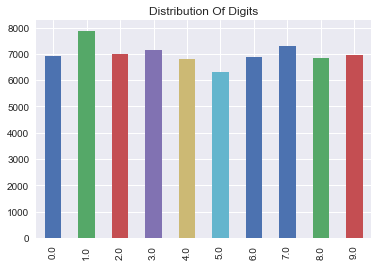

In [156]:
pd.DataFrame(mnist['target'])[0].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution Of Digits');

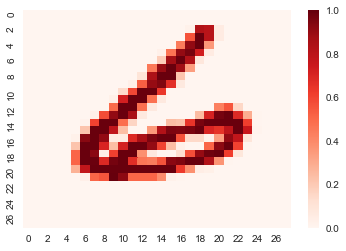

In [157]:
idx=np.random.randint(mnist['data'].shape[0])
digit=mnist['data'][idx]
sz=int(np.sqrt(digit.shape[0]))
df=pd.DataFrame(digit.reshape(sz,sz))
df=df/df.max().max()
sns.heatmap(df,cmap='Reds');

## Convolution For Layer 1

In [158]:
'''
Convolution Kernels:
In this case, two filters are implemented to detect different shapes.
First filter detects horizontal edges and second filter detects vertical edges.

fl1 is a list of kernels in the first layer.
'''
fl1=[[[1,1,1],
    [0,0,0],
    [-1,-1,-1]],
     
    [[1,0,-1],
    [1,0,-1],
    [1,0,-1]]]

In [159]:
def operation(df,kernel,i,j):
    return int(np.multiply(np.array(df.iloc[i:i+3,j:j+3]),kernel).sum())

def create_conv(dfs,ks):
    conv=pd.DataFrame(0, index=range(dfs[0].shape[0]-2),columns=range(dfs[0].shape[0]-2))
    for i in range(conv.shape[0]):
        for j in range(conv.shape[0]):
            # RELU implemented within activation i.e. max(0,SUM(matrix*kernel))
            conv.iloc[i,j]=max(0,np.sum([operation(df,k,i,j) for df,k in zip(dfs,ks)]))
    return conv

In [160]:
'''
A matrix of activations after all 3x3 sections of the input are multiplied by the
convolutional kernel. 
NOTE: This is stored as a 2d array, however it is really a stacked Tensor where each 
matrix represents a slice of the tesnor.
'''

# List of Convolutional Matricies e.g. First Hidden Layer
convl1=[create_conv([df],[f]) for f in fl1]

### Convolution Matrix (Activation Matrix)

In [161]:
from IPython.display import Image
Image(url= "https://cdn-images-1.medium.com/max/1600/1*F96jmLp1Ljx4UjtMmhlLmQ.png")

### Activation Function

In [162]:
Image(url= "https://cdn-images-1.medium.com/max/1200/1*QindKA4Dt7Ol3CbICMSxWw.png")

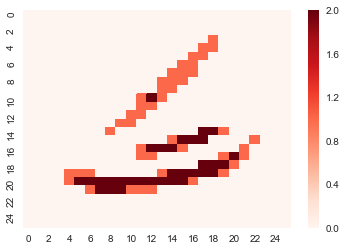

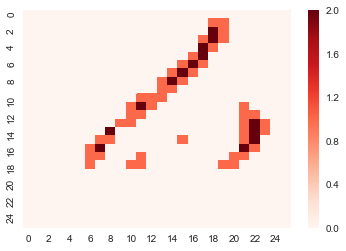

In [163]:
for conv in convl1:
    sns.heatmap(conv,cmap='Reds');
    plt.show()

## Repeat Convolution For Layer 2

In [164]:
# List of Kenernels for Layer 2

fl2_1=[[[.516,.267,.257],
    [.859,-.517,.049],
    [.802,.013,-.671]],
       
    [[.827,.366,.549],
    [.569,.36,.3],
    [.318,.696,.592]]]

fl2_2=[[[.017,.258,.436],
    [.555,.195,.174],
    [-.956,.444,.634]],
       
    [[.794,.184,.688],
    [-.874,.399,.538],
    [.234,.158,.837]]]

In [165]:
convl2=[create_conv(convl1,f) for f in zip(fl2_1,fl2_2)]

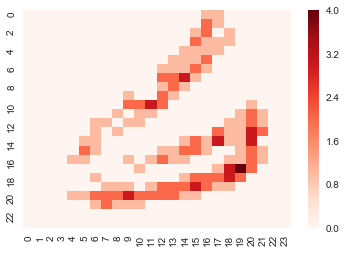

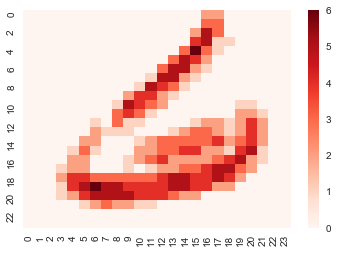

In [166]:
for conv in convl2:
    sns.heatmap(conv,cmap='Reds');
    plt.show()

## Max Pooling

In [167]:
def max_pool(df):
    mp=pd.DataFrame(0, index=range(int(df.shape[0]/2)),columns=range(int(df.shape[0]/2)))
    for idx,i in enumerate(range(0,df.shape[0],2)):
        for jdx,j in enumerate(range(0,df.shape[0],2)):
            mp.iloc[idx,jdx]=df.iloc[i:i+2,j:j+2].max().max()
    return mp

In [168]:
'''
Max pooling is going half the resolution of the height and width 
by only taking the maximum of a 2x2 section in Convolutions of Layer 2.  
Pooling is faster to compute than convolutions.
'''

# List of Max_Pool Matricies
mps=[max_pool(conv) for conv in convl2]

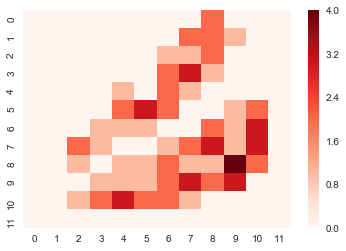

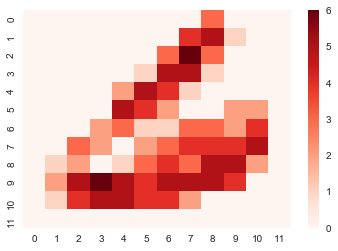

In [169]:
for mp in mps:
    sns.heatmap(mp,cmap='Reds');
    plt.show()

## Fully Connected Layer (Dense Layer)

In [170]:
'''
Build fully connected layer by taking all of our activations in Maxpool 
and give them all a weight. Then take the SUMPRODUCT of the activations and the weights.

Instead of parsing each section in a convolution layer as before, 
a fully connected layer will (Dense Layer) will perform the 
classification on the features that were extracted by the 
convolutional layers and downsampled by the max-pooling layers.

Here we would need 10 sets of fully connected layers for each digit.
'''
# List of dense weights matricies for a specific digit
dws=[[pd.DataFrame(np.random.random((mp.shape[0], mp.shape[1])))
    for mp in mps] for i in range(10)]

In [171]:
# dense activation for a specific digit
das=[sum([np.dot(mp,dw).sum() for mp,dw in zip(mps,dws_set)]) for dws_set in dws]

In [182]:
i=6
results=pd.DataFrame(das,index=range(10),columns=['da'])
results['class']=0
results.loc[i,'class']=1000
def f(x):
    return 0.5*(x['class']-x['da'])**2
results['E']=results[['class','da']].apply(lambda x: f(x), axis=1)

MSE=results['E'].sum()
MSE

14192095.909097767

In [ ]:
# Creates a simple random forest benchmark
import pandas

train = pandas.read_csv("../input/train.csv")
test = pandas.read_csv("../input/test.csv")

from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier

    
def accuracy(predictions):
    count = 0.0
    for i in range(len(predictions)):
        if predictions[i] == train["label"][i]:
            count = count + 1.0
            
    accuracy = count/len(predictions)
    print ("--- Accuracy value is " + str(accuracy))
    return accuracy

predictors = []
for i in range(784):
    string = "pixel" + str(i)
    predictors.append(string)


# Initialize our algorithm with the default paramters
# n_estimators is the number of trees we want to make
# min_samples_split is the minimum number of rows we need to make a split
# min_samples_leaf is the minimum number of samples we can have at the place where a tree branch ends (the bottom points of the tree)
alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=2, min_samples_leaf=1)

print ("Using "+ str(alg))
print

# Compute the accuracy score for all the cross validation folds. 
scores = cross_validation.cross_val_score(alg, train[predictors], train["label"], cv=3)

# Take the mean of the scores (because we have one for each fold)
print (scores)
print("Cross validation scores = " + str(scores.mean()))


full_predictions = []
# Fit the algorithm using the full training data.
alg.fit(train[predictors], train["label"])
# Predict using the test dataset.  
predictions = alg.predict_proba(train[predictors]).astype(float)
predictions = predictions.argmax(axis=1)

submission = pandas.DataFrame({
        "true value": train["label"],
        "label": predictions
    })

accuracyV = accuracy(predictions)

# Compute accuracy by comparing to the training data.
#accuracy = (sum(predictions[predictions == train["label"]])).astype(float) / len(predictions)
#print accuracy

filename = str('%0.5f' %accuracyV) + "_test_mnist.csv"
submission.to_csv(filename, index=False)

full_predictions = []
# Fit the algorithm using the full training data.
alg.fit(train[predictors], train["label"])
# Predict using the test dataset.  We have to convert all the columns to floats to avoid an error.
predictions = alg.predict_proba(test[predictors]).astype(float)

predictions = predictions.argmax(axis=1)
ImageId = []
for i in range(1, 28001):
    ImageId.append(i)

submission = pandas.DataFrame({
        "ImageId": ImageId,
        "Label": predictions
    })
    
submission.to_csv("kaggle_mnist.csv", index=False)